<!--NAVIGATION-->
< [Introduction](Introduction.ipynb) | [Contents](Contents.ipynb) | [Condition 1](Condition_1.ipynb) >

# 2. Preparation
## 2.1 Introduction
For this task you are provided with the following raster layers: `buildg.tif`, `roads.tif`, `dtm.tif`, and `gwlevel.tif`. You can find these files in the `data` folder.

To work with PCRaster we need to convert the files to the PCRaster format. You can do that from the command line using the GDAL commands. Here we'll do the conversion with the GDAL Python library.

## 2.2 Convert rasters with GDAL

Let's convert the `buildg.tif` file.
First we import `gdal` and `gdalconst` from the `osgeo` library:

In [ ]:
#Z_1tiff2PCraster and Z_2getRaster --> for automating data preparation

In [21]:
from osgeo import gdal, gdalconst
from pcraster import *

Then we read the GeoTIFF from our `data` folder.

In [22]:
src_ds = gdal.Open( "data/buildg.tif" )

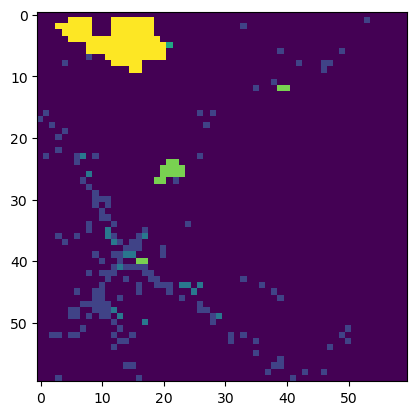

In [23]:
#ploting with gdal -->FF
import matplotlib.pyplot as plt

band = src_ds.GetRasterBand(1)
data = band.ReadAsArray()
plt.imshow(data)
plt.show()

In [24]:
#To see the image you need geopandas, rasterio or just aguila build.tif(cmd) --FF
#python pcraster

#toibe found

Next we can use the Python equivalent of [`gdal_translate`](https://gdal.org/programs/gdal_translate.html#gdal-translate): `Translate`. We need to use the name of the format. See [GDAL Raster drivers (short name)](https://gdal.org/drivers/raster/index.html) for formats. In our case the output format is `PCRaster`.

We also need to define the data type of the output.

PCRaster uses data typing of the data in the database: each map has one of the six data types used attached to it. These data types help you and PCRaster to structure the data. See the table below.<br>

| data type | description of attributes | domain | example |
|:-------:|:-------:|:-------:|:-------:|
| boolean | boolean | 0 (FALSE),<br> 1 (TRUE) | suitable/unsuitable, visible/non visible |
| nominal |	classified, no order | whole values | soil classes |
| ordinal | classified, order | whole values | succession stages, income groups |
| scalar | continuous, linear | real values | temperature, concentration |
| directional | continuous, directional | 0 to 360 degrees | aspect |
| ldd | direction to neighbour cell | codes of directions | drainage networks |

In the arguments of `Translate` you need to define the `outputType` and `metadataOptions` based on the table below. Note that we can only convert boolean, nominal and scalar rasters. The ldd and directional rasters are created within PCRaster. For scalar we can use Float 32 or Float 64, depending on the desired precision.

| data type | `outputType` | `metadataOptions` |
|:-------:|:-------:|:-------:|
| boolean | `gdalconst.GDT_Byte` | `'VS_BOOLEAN'`|
| nominal | `gdalconst.GDT_Int32` | `'VS_NOMINAL'`|
| scalar | `gdalconst.GDT_Float32` | `'VS_SCALAR'`|
| scalar | `gdalconst.GDT_Float64` | `'VS_SCALAR'`|

`buildg.tif` is a nominal raster. It contains classes. Therefore the code we'll use for `Translate` is:

In [25]:
dst_ds = gdal.Translate('data/buildg.map', src_ds, format='PCRaster', \
                        outputType=gdalconst.GDT_Int32, metadataOptions='VS_NOMINAL')

And we properly close the datasets to flush to disk:

In [26]:
dst_ds = None
src_ds = None

Now you can find the file `buildg.map` on your hard disk. Check if that's the case if you're running this notebook locally.

Let's apply the same code to the other files `dtm.tif`, `roads.tif` and `gwlevel.tif`. In this case it's easier to write it as a function.

In [27]:
#Import gdal
from osgeo import gdal

def ConvertToPCRaster(src_filename,dst_filename,ot,VS):
    #Open existing dataset
    src_ds = gdal.Open(src_filename)
    
    #GDAL Translate
    dst_ds = gdal.Translate(dst_filename, src_ds, format='PCRaster', outputType=ot, metadataOptions=VS)
    
    #Properly close the datasets to flush to disk
    dst_ds = None
    src_ds = None
    
ConvertToPCRaster("data/buildg.tif","data/buildg.map",gdalconst.GDT_Int32,"VS_NOMINAL")
ConvertToPCRaster("data/roads.tif","data/roads.map",gdalconst.GDT_Int32,"VS_NOMINAL")
ConvertToPCRaster("data/gwlevel.tif","data/gwlevel.map",gdalconst.GDT_Float32,"VS_SCALAR")
ConvertToPCRaster("data/dtm.tif","data/dtm.map",gdalconst.GDT_Float32,"VS_SCALAR")

## 2.3 Inspecting the data
For map algebra the properties of all raster layers used in calculations need to be the same.
Let's find out if they have the same number of rows and columns, coordinates and pixel size.

Let's open a PCRaster file with GDAL.

In [28]:
RasterLayer = gdal.Open("data/dtm.map")

To get the numbers of rows and columns we can use the GDAL functions `RasterXSize` and `RasterYSize`.
`RasterLayer.GetDescription()` gives the relative path of the layer.

In [29]:
Path = RasterLayer.GetDescription()
NrColumns = RasterLayer.RasterXSize
NrRows = RasterLayer.RasterYSize
print('{} has {} columns and {} rows'.format(Path,NrColumns,NrRows ))

data/dtm.map has 60 columns and 60 rows


To know the coordinates and pixel size we can use `GetGeoTransform` from GDAL.
It returns a tuple with the following information:

`RasterLayer.GetGeoTransform[0]`: Top left X coordinate

`RasterLayer.GetGeoTransform[1]`: West-East pixel resolution

`RasterLayer.GetGeoTransform[2]`: Rotation, 0 for "north up"

`RasterLayer.GetGeoTransform[3]`: Top left Y coordinate

`RasterLayer.GetGeoTransform[4]`: Rotation, 0 for "north up"

`RasterLayer.GetGeoTransform[5]`: North-South pixel resolution (negative)

In [30]:
RasterLayer.GetGeoTransform()

(288674.671, 50.0, 0.0, 3352810.143, 0.0, -50.0)

Let's present that more readable.

In [31]:
print("Origin = ({}, {})".format(RasterLayer.GetGeoTransform()[0], RasterLayer.GetGeoTransform()[3]))
print("Pixel Size = ({}, {})".format(RasterLayer.GetGeoTransform()[1],RasterLayer.GetGeoTransform()[5]))

Origin = (288674.671, 3352810.143)
Pixel Size = (50.0, -50.0)


We can also use GDAL to get the projection information. The PCRaster format doesn't store the projection information, but when we converted the rasters it saves an XML file with the projection info. The GDAL function is `GetProjection()`.

In [33]:
RasterLayer.GetProjection()

'PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]'

That gives us a string in the OGC WKT format.
In order to make the projection and the units readable, we need to parse the OGC WKT string. For that we'll use the [PyCRS](https://pypi.org/project/PyCRS/) library. 

If it's not installed yet if you run this notebook locally, you can install the library by typing the following at the Anaconda prompt:

`conda install -c conda-forge pycrs`

First we import the library and save the OGC WKT string in a variable that we parse.

In [36]:
import pycrs
RasterLayerProjection = RasterLayer.GetProjection()

# Parse OGC WKT string
crs = pycrs.parse.from_ogc_wkt(RasterLayerProjection)

We can check if it is a projected coordinate system:

In [37]:
isinstance(crs, pycrs.ProjCS)

True

The result is `True` so we're not dealing with a Geographical Coordinate System.
Let's get the name of the projection.

In [38]:
ProjectionName = crs.name
print(ProjectionName)

WGS 84 / UTM zone 30N


We can also get the units of the projection:

In [39]:
ProjectionUnits = crs.unit.unitname.ogc_wkt
print(ProjectionUnits)

Meters


Finally it would be useful to get some statistics from the raster layer. Let's calculate the minimum and maximum value.
Because raster layers can have multiple bands we need to select the band. In our case we have a single band raster layer, so we have to choose band 1.

In [42]:
RasterLayerBand = RasterLayer.GetRasterBand(1)
RasterLayerBand

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7fcd73499680> >

Now we can calculate the minumum and maximum value of the band using respectively `GetMinimum` and `GetMaximum`.

In [41]:
RasterLayerMinimum = RasterLayerBand.GetMinimum()
RasterLayerMaximum = RasterLayerBand.GetMaximum()
print("Minimum: ", RasterLayerMinimum)
print("Maximum: ", RasterLayerMaximum)

Minimum:  201.0
Maximum:  298.0


Let's write this in a function and get the raster layer properties for all the raster layers so we can compare.

In [43]:
from osgeo import gdal
import pycrs

def RasterLayerProperties(RasterLayer):
    print("Raster file: {}".format(RasterLayer.GetDescription()))
    print("Driver: {}/{}".format(RasterLayer.GetDriver().ShortName,
                            RasterLayer.GetDriver().LongName))
    print("Size is {} x {} x {}".format(RasterLayer.RasterXSize,
                                    RasterLayer.RasterYSize,
                                    RasterLayer.RasterCount))
    RasterLayerProjection = RasterLayer.GetProjection()
    crs = pycrs.parse.from_ogc_wkt(RasterLayerProjection)
    print("Projection:",crs.name)
    print("Map units:",crs.unit.unitname.ogc_wkt)
    geotransform = RasterLayer.GetGeoTransform()
    if geotransform:
        print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
        print("Pixel Size = ({} {}, {} {})".format(geotransform[1],crs.unit.unitname.ogc_wkt, \
                                                   geotransform[5],crs.unit.unitname.ogc_wkt))
        
    RasterLayerBand = RasterLayer.GetRasterBand(1)
    print("Minimum: {}".format(RasterLayerBand.GetMinimum()))
    print("Maximum: {}".format(RasterLayerBand.GetMaximum()))
    
    print()
    RasterLayer = None
    
    
DTMLayer = gdal.Open( "data/dtm.map" )
RasterLayerProperties(DTMLayer)

BuildgLayer = gdal.Open( "data/buildg.map" )
RasterLayerProperties(BuildgLayer)

RoadsLayer = gdal.Open( "data/roads.map" )
RasterLayerProperties(RoadsLayer)

GWLevelLayer = gdal.Open( "data/gwlevel.map" )
RasterLayerProperties(GWLevelLayer)

Raster file: data/dtm.map
Driver: PCRaster/PCRaster Raster File
Size is 60 x 60 x 1
Projection: WGS 84 / UTM zone 30N
Map units: Meters
Origin = (288674.671, 3352810.143)
Pixel Size = (50.0 Meters, -50.0 Meters)
Minimum: 201.0
Maximum: 298.0

Raster file: data/buildg.map
Driver: PCRaster/PCRaster Raster File
Size is 60 x 60 x 1
Projection: WGS 84 / UTM zone 30N
Map units: Meters
Origin = (288674.671, 3352810.143)
Pixel Size = (50.0 Meters, -50.0 Meters)
Minimum: 0.0
Maximum: 5.0

Raster file: data/roads.map
Driver: PCRaster/PCRaster Raster File
Size is 60 x 60 x 1
Projection: WGS 84 / UTM zone 30N
Map units: Meters
Origin = (288674.671, 3352810.143)
Pixel Size = (50.0 Meters, -50.0 Meters)
Minimum: 0.0
Maximum: 2.0

Raster file: data/gwlevel.map
Driver: PCRaster/PCRaster Raster File
Size is 60 x 60 x 1
Projection: WGS 84 / UTM zone 30N
Map units: Meters
Origin = (288674.671, 3352810.143)
Pixel Size = (50.0 Meters, -50.0 Meters)
Minimum: 127.98716735839844
Maximum: 274.8428955078125



In [22]:
#Minimum=%.3f, Maximum=%.3f, Mean=%.3f, StdDev=%.3f" % ( \stats[0], stats[1], stats[2], stats[3]
stats = RasterLayerBand.GetStatistics(False, True) 
stats

[201.0, 298.0, 253.37611111111, 18.904913717188]

In [23]:
#BAnd dataset info GFM Material

print("min = %.2f max = %.2f mean = %.2f std = %.2f" % (stats[0], stats[1], stats[2], stats[3]))
print(f'No data value: {RasterLayerBand.GetNoDataValue()}')

min = 201.00 max = 298.00 mean = 253.38 std = 18.90
No data value: -3.4028234663852886e+38


In [44]:
#Experimenting with GFM material

from osgeo import gdal
from osgeo import gdal_array as gdarr
import numpy as np



px = RasterLayerBand.ReadAsArray()
if px is not None:
    print(type(px))
    print('shape', px.shape)
    print('pixelvalue', px[0,0]) #value in0,0
    print('Raster data: \n', px)

   



<class 'numpy.ndarray'>
shape (60, 60)
pixelvalue 272.0
Raster data: 
 [[272. 270. 269. ... 245. 245. 245.]
 [273. 271. 269. ... 246. 246. 246.]
 [280. 274. 270. ... 249. 249. 249.]
 ...
 [237. 240. 242. ... 254. 254. 255.]
 [232. 237. 241. ... 253. 256. 256.]
 [231. 234. 239. ... 253. 255. 257.]]


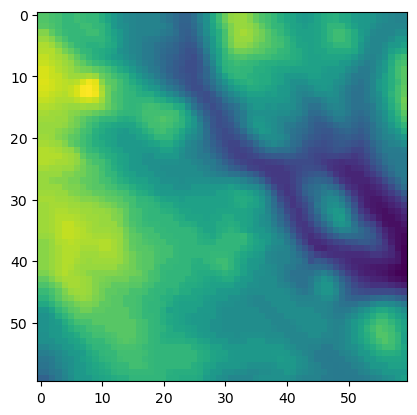

In [50]:
##Ploting 

import matplotlib.pyplot as plt
#Now passing as an array and printing 
# use 0;0 for the topleft pixel; -1; -1 for the bottomright
xoff = -1
yoff = -1

# use 1-1 to extract a single pixel, otherwise extract multiple pixels
win_xsize = 60
win_ysize = 60  

px = gdarr.BandReadAsArray(RasterLayerBand, xoff, yoff, win_xsize, win_ysize)
px[px == -9999] = None # or just use band.GetNoDataValue()
plt.imshow(px)
plt.show()

In [45]:
#extract a subset
##################

# use 0;0 for the topleft pixel; -1; -1 for the bottomright
xoff = -1
yoff = -1

# use 1-1 to extract a single pixel, otherwise extract multiple pixels
win_xsize = 30
win_ysize = 30

# read a single band as a 2D array
px = gdarr.BandReadAsArray(RasterLayerBand, xoff, yoff, win_xsize, win_ysize)
print(type(px))
print('shape', px.shape)

# use 0;0 for the topleft pixel; -1; -1 for the bottomright
print('topleft', px[0,0])
print('bottomright', px[-1,-1])


<class 'numpy.ndarray'>
shape (30, 30)
topleft 272.0
bottomright 257.0


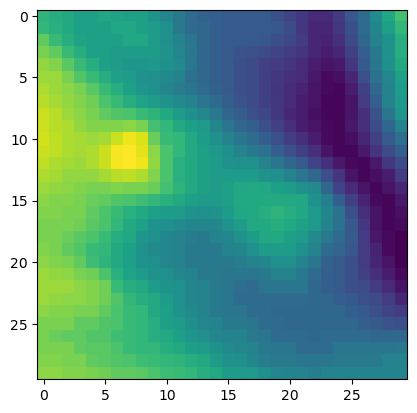

In [46]:
#Ploting the subset

import matplotlib.pyplot as plt

# use 0;0 for the topleft pixel; columns-1; rows-1 for the bottomright
xoff = 0
yoff = 0
# use 1-1 to extract a single pixel, otherwise extract multiple pixels
win_xsize = 30
win_ysize = 30

px = gdarr.BandReadAsArray(RasterLayerBand, xoff, yoff, win_xsize, win_ysize)
px[px == -9999] = None # or just use band.GetNoDataValue()
plt.imshow(px)
plt.show()

In [86]:
print(os.getcwd())

/mnt/c/Users/felip/OneDrive - Universidad Nacional de Colombia/2_Formation/DataSc/2_SpatialDS/3_PrGeoHydApp/1_IHE_py4hydro/3_MapAlPcrtut/1_MapAlgebra


In [89]:
# #USING GDAL SCRIPTS -gdal2xyz.py -csv input.tif result.csv
# import os


# Directory = "home/felwind14/miniconda3/envs/pcraster/lib/python3.11/site-packages/osgeo_utils/"


# def run_script(params):
#     import subprocess
#     params.insert(0,"py")
#     p = subprocess.Popen(params, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#     out, err = p.communicate()
#     if bytes.decode(err) != '':
#         raise ValueError(bytes.decode(err))
#     else:
#         return bytes.decode(out)

# #change to the data directory
# data_dir='/mnt/c/Users/felip/OneDrive - Universidad Nacional de Colombia/2_Formation/DataSc/2_SpatialDS/3_PrGeoHydApp/1_IHE_py4hydro/3_MapAlPcrtut/1_MapAlgebra/data'
# os.chdir(data_dir)
# run_script([Directory + "/gdal2xyz.py", "-csv",'-b','1', 'fdtm.map','fdem.csv'])
# print ("Done")


# import os
# import subprocess

# Directory = r"/mnt/wsl.localhost/Ubuntu-22.04/home/felwind14/miniconda3/envs/pcraster/lib/python3.11/site-packages/osgeo_utils/"

# def run_script(params):
#     p = subprocess.Popen(params, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#     out, err = p.communicate()
#     if err:
#         raise ValueError(err.decode())
#     else:
#         return out.decode()

# # Change to the data directory
# data_dir = '/mnt/c/Users/felip/OneDrive - Universidad Nacional de Colombia/2_Formation/DataSc/2_SpatialDS/3_PrGeoHydApp/1_IHE_py4hydro/3_MapAlPcrtut/1_MapAlgebra/data'
# os.chdir(data_dir)

# # Full path to the Python interpreter
# python_interpreter = '/mnt/wsl.localhost/Ubuntu-22.04/home/felwind14/miniconda3/envs/pcraster/bin/python'

# # Script path
# script_path = os.path.join(Directory, "gdal2xyz.py")

# run_script([python_interpreter, script_path, "-csv", "-b", "1", "fdtm.map", "fdem.csv"])
# print("Done")



FileNotFoundError: [Errno 2] No such file or directory: 'py'

Based on these results we can conclude that the raster layers have the same properties and are suitable for map algebra.

<!--NAVIGATION-->
< [Introduction](Introduction.ipynb) | [Contents](Contents.ipynb) | [Condition 1](Condition_1.ipynb) >